# Realistic alternatives: Substituting the worst train connections with electrified highways.

## 1. Introduction
<!-- Introduces the problem and motivates your work --> 

Travel time is one of the most important factors in the decision for a mode of transportation.
This project aims to give insights into the extent of the advantage of travel by car over travel by train. 
Routes which are significantly faster by car are analysed with respect to their degree of electrification.
A suggestion for improvements to the charging infrastructure will be made. 
Infrastructure projects such as new railways take up years in planning and executing.
With the spirit of "free passage for free citizens" ("Freie Fahrt für freie Bürger"), a reasonable and at the same time 
environmentally friendly alternative is presented: choosing the fast and flexible travel by car, but opting for EVs instead of fossil fuels.

#### Main Question
Which routes between German cities are the fastest by car (in comparison to travel by train) and should be electrified 
for a "quick win" (compared to new train tracks) in climate action?

## 2. Methods
<!-- Describes which data sources you used and why, how you built your data pipeline and which data cleaning / transformation steps you followed as well as any problems encountered during data engineering -->
#### 2.1 Data Sources
The three data sources allow to firstly analyze the connectivity between cities and secondly, they allow for a judgement about the electrification of routes between cities.

<b>Datasource 1: Connectivity between largest German Cities ("Connectivity")</b>

This RDF-Star knowledge graph shows how well the 100 largest (by population) cities in Germany are connected.
It allows to compare travel by train, car and plane with respect to travel time. 

<b>Datasource 2: List of Electric Vehicle (EV) Charging Points in Germany ("Chargers")</b>

Registry of all publicly accessible charging points registered at the German authority for infrastructure (Bundesnetzagentur).
Contains information on location (address and coordinates) and charging point type/capacity.

<b>Datasource 3: EV Charging Point Infrastructure in Germany ("Development")</b>

This overview on the charging point infrastructure in Germany provides information on the number of charging points per federal state, city and district, as well as the historical evolution of the infrastructure.

#### 2.2 Data Pipelines
The project utilizes three different data pipelines, one for each data source.

<b>Data Pipeline 1: Connectivity</b>

The data is available as a knowledge graph. In the pipeline, the archived graph is downloaded, unpacked and serialized into a list of triples. Each triple is processed one at a time, where firstly, all triples which contain a formalization of a route are extracted. Secondly, all attributes describing the routes are extracted and both are matched in one tabular data structure. Thirdly, as some graph edges are not labelled in plain text, the labels of all edges are extracted from the graph and replace the data in the data table.
Finally, driving durations are converted to minutes and distances are converted to kilometers.

<b>Data Pipeline 2: Chargers</b>

The pipeline downloads a registry of all ev charging points in Germany. The data is available as a csv file. Firstly, the first rows, containing only a preamble, are removed. Then the column names of the table are replaced with English labels. Afterwards, geographic coordinated as well as the capacity of the chargers are saved as floating point values. Finally, completely empty rows are removed, and the data is saved.

<b>Data Pipeline 3: Development</b>

The data is published as an Excel sheet, where only one of several tables is relevant to this project. The relevant table and sheet range are selected and saved to a table. The table contains names of all districts, but in no uniform format. Therefore, all pre- and suffixes of district names are removed, to align the names with potential other datasets. For each district, the dataset contains quarterly counts of chargers, split into three categories of chargers (fast, regular and total). For this project, this is too fine-granular, so the number of total charging points in january of every year is selected from the table, and saved as the final dataset.

#### 2.3 Challenges
The three datasets came either from government projects or government offices, but still turned out to be challenging to work with. 
Firstly the districts ("Landkreise") were ambiguously named: some contained a prefix ("Landkreis") or suffix ("-Kreis) and some did not. This made it hard to match the districts with the labels of maps, ultimately leading to the decision of plotting information at the state level, and not at the district level.

Also, some metrics were just too expensive to calculate (ex. coverage %).

## 3. Results

In [1]:
%cd ..
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

/Users/lisaschmidt/Documents/GitHub/data-engineering-showcase


In [2]:
from project.route_processing import aggregate_travel_modes, calculate_absolute_deviation, calculate_relative_deviation, compute_connectivity_metrics

In [3]:
from project.geographical_visualizations import plot_routes_on_germany_map

### Comparing Train Travel to Travel by Car

Firstly, all routes are loaded from the database.

In [4]:
cnx = sqlite3.connect('data/connections.sqlite')
df_connections = pd.read_sql_query("SELECT * FROM connections", cnx)
df_connections

,start,end,transport_type,route,duration,driving_distance
0,Bremerhaven,Marl,car,LINESTRING(8.586580000000001 53.55175000000000...,152,288.831379
1,Bremerhaven,Marl,train,None,320,NaN
2,Bremerhaven,Marl,train,None,385,NaN
3,Bremerhaven,Marl,train,None,322,NaN
4,Dortmund,Karlsruhe,car,"LINESTRING(7.46417 51.51505, 7.461770000000000...",200,355.366236
...,...,...,...,...,...,...
40510,Chemnitz,Osnabrück,train,None,320,NaN
40511,Halle (Saale),Bielefeld,car,LINESTRING(11.970030000000001 51.4824400000000...,180,344.566496
40512,Halle (Saale),Bielefeld,train,None,231,NaN
40513,Halle (Saale),Bielefeld,train,None,192,NaN


Secondly, all routes taken by car and by train are made comparable by aggregating the routes.

In [5]:
df_connectivity = aggregate_travel_modes(df_connections)
df_connectivity['absolute_deviation'] = df_connectivity.apply(calculate_absolute_deviation, axis=1)
df_connectivity['relative_deviation'] = df_connectivity.apply(calculate_relative_deviation, axis=1)
df_connectivity[["start", "end", "absolute_deviation", "relative_deviation"]].sort_values(by="relative_deviation")

,start,end,absolute_deviation,relative_deviation
1920,Erfurt,Marl,-196,-93.779904
5801,Marl,Erfurt,-194,-93.269231
4958,Leipzig,Marl,-181,-74.485597
3096,Halle (Saale),Marl,-163,-73.755656
5813,Marl,Halle (Saale),-160,-73.732719
...,...,...,...,...
646,Bottrop,Marl,298,1655.555556
3782,Herne,Marl,271,1806.666667
5820,Marl,Herne,305,1906.250000
7507,Recklinghausen,Marl,320,3200.000000


The city Marl is involved in all outliers, interestingly, as lower and upper outlier, suggesting that the measurements were faulty, or influenced by a incident on the routes. For the following analysis, the routes involving Marl are excluded.

In [6]:
df_connectivity = df_connectivity[df_connectivity.start != "Marl"][df_connectivity.end != "Marl"]

/var/folders/9l/2lhc2hnd6px5hd0bxlsy1rh80000gn/T/ipykernel_18296/386649411.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_connectivity = df_connectivity[df_connectivity.start != "Marl"][df_connectivity.end != "Marl"]


In [7]:
df_connectivity[["start", "end", "absolute_deviation", "relative_deviation"]].sort_values(by="relative_deviation", ascending=False)

,start,end,absolute_deviation,relative_deviation
1628,Duisburg,Moers,27,245.454545
7525,Recklinghausen,Remscheid,84,233.333333
7733,Remscheid,Velbert,57,228.000000
9152,Witten,Herne,31,221.428571
3816,Herne,Witten,31,221.428571
...,...,...,...,...
6190,Mülheim an der Ruhr,Duisburg,-10,-62.500000
6796,Offenbach am Main,Hanau,-14,-63.636364
2120,Essen,Mülheim an der Ruhr,-9,-64.285714
2683,Gelsenkirchen,Herne,-8,-66.666667


Definitions:

Absolute deviation: Travelling from Duisburg to Moers is 27 Minutes longer by train than by car.

Relative deviation: Travelling from Recklinghausen to Remscheid takes 233% longer by train than by car.

In [8]:
len(df_connectivity[df_connectivity.absolute_deviation > 0])/len(df_connectivity)

0.7642541552703556

For more than 75% of the routes, taking the car is faster than taking the train.

In [9]:
print(f"""On average, travelling a route by train takes {round(df_connectivity["absolute_deviation"].mean(),2)} minutes longer than by car.""")
print(f"""On average, travelling a route by train takes {round(df_connectivity["relative_deviation"].mean(),2)}% longer than by car.""")

On average, travelling a route by train takes 30.03 minutes longer than by car.
On average, travelling a route by train takes 19.25% longer than by car.


The 20 routes with the highest % deviation between car travel and train travel:

In [10]:
highest_rel_dev = df_connectivity.sort_values(by="relative_deviation", ascending=False)[:50]
highest_rel_dev[["start", "end", "relative_deviation", "driving_distance"]].head()

,start,end,relative_deviation,driving_distance
1628,Duisburg,Moers,245.454545,14.689648
7525,Recklinghausen,Remscheid,233.333333,59.918343
7733,Remscheid,Velbert,228.000000,28.061773
9152,Witten,Herne,221.428571,17.756796
3816,Herne,Witten,221.428571,18.573968


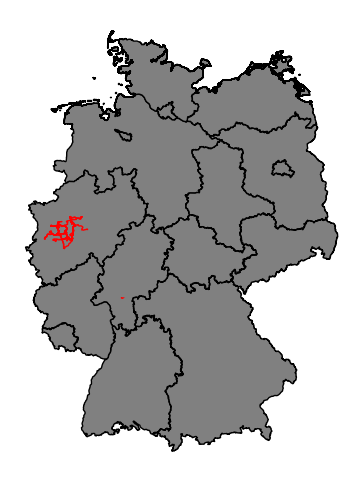

In [11]:
plot_routes_on_germany_map(highest_rel_dev)

The routes with the highest relative deviation between train travel and car travel concentrate in the State Nordrhein-Westfalen and around Frankfurt am Main. They are short- to medium-distance travel routes (< 65km).

In [12]:
highest_abs_dev = df_connectivity.sort_values(by="absolute_deviation", ascending=False)[:50]
highest_abs_dev[["start", "end", "absolute_deviation", "driving_distance"]][:5]

,start,end,absolute_deviation,driving_distance
4616,Konstanz,Chemnitz,225,612.608189
1026,Chemnitz,Konstanz,224,612.714833
4617,Konstanz,Cottbus,223,782.250092
1070,Chemnitz,Villingen-Schwenningen,217,542.602797
1168,Cottbus,Villingen-Schwenningen,216,712.144679


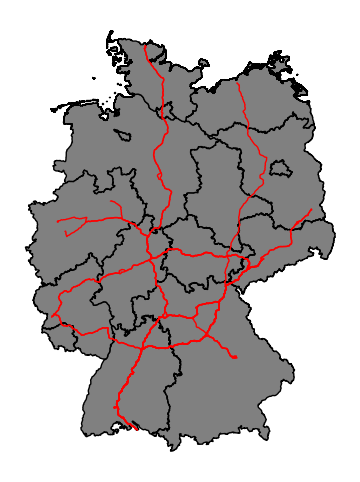

In [13]:
plot_routes_on_germany_map(highest_abs_dev[:20])

The routes with the highest absolute disadvantage of taking a train (instead of a car) are routes which stretch over all of Germany. They are long-distance routes (> 500km).

In [14]:
df_routes_to_analyse = highest_abs_dev

For the following analyses, only the routes with the highest absolute deviation are used, as they are spread well over all of Germany and allow to analyse a larger portion of the German ev chargin infrastructure.

In [15]:
cnx = sqlite3.connect('data/charging_points_germany.sqlite')
df_chargers = pd.read_sql_query("SELECT * FROM chargers", cnx)
df_chargers

,operator,city,state,district,latitude,longitude,rated_capacity
0,Albwerk GmbH & Co. KG,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.442398,9.659075,22.0
1,smopi,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.449353,9.672201,22.0
2,Albwerk GmbH & Co. KG,Westerheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.510500,9.609000,22.0
3,EnBW mobility+ AG und Co.KG,Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.578534,9.874840,98.0
4,SWU Energie GmbH,Balzheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.179959,10.076977,22.0
...,...,...,...,...,...,...,...
54218,TEAG Mobil GmbH,Obertrebra,Thüringen,Landkreis Weimarer Land,51.060798,11.565503,300.0
54219,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54220,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54221,TEAG Mobil GmbH,Großheringen,Thüringen,Landkreis Weimarer Land,51.107188,11.659489,30.0


The following calcualtes two metrics for the routes which have shown the greatest disadvatage of train travel. Firstly, the density of chargers along the route is calculated (chargers/length of route). Secondly, the average distance to the next charger is calculated. This is done by sampling points along the route, and then calculating the distance to the nearest charger within close proximity to the route.

In [16]:
densities, distances = compute_connectivity_metrics(df_chargers, df_routes_to_analyse)

100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


In [17]:
df_routes_to_analyse['charger_density'] = densities
df_routes_to_analyse['avg_dist_charger'] = distances
df_routes_to_analyse[["start", "end", "driving_distance", "absolute_deviation", "relative_deviation","charger_density", "avg_dist_charger"]].sort_values(by="avg_dist_charger", ascending=False)

,start,end,driving_distance,absolute_deviation,relative_deviation,charger_density,avg_dist_charger
7930,Rostock,Villingen-Schwenningen,927.829617,171,35.477178,0.000564,2820.340949
7887,Rostock,Konstanz,990.636424,196,38.132296,0.000568,2740.096567
4617,Konstanz,Cottbus,782.250092,223,52.470588,0.000556,2445.740567
5487,Lünen,Zwickau,469.720700,161,65.983607,0.000425,2406.597703
7545,Recklinghausen,Zwickau,496.218955,169,66.274510,0.000415,2380.626331
7458,Recklinghausen,Chemnitz,520.519639,171,63.805970,0.000388,2371.440557
4028,Iserlohn,Chemnitz,505.403187,176,67.432950,0.000433,2345.937506
9680,Zwickau,Recklinghausen,491.175042,158,60.769231,0.000429,2340.385242
8427,Sterkrade,Zwickau,521.880456,181,67.537313,0.000406,2338.280964
9211,Witten,Zwickau,476.510255,160,64.257028,0.000426,2321.538367


In [18]:
df_routes_to_analyse["charger_density"].mean()

0.0005541390133131204

In [19]:
df_routes_to_analyse["avg_dist_charger"].mean()

2168.981333061286

Text(197, 2700, 'Rostock->Konstanz')

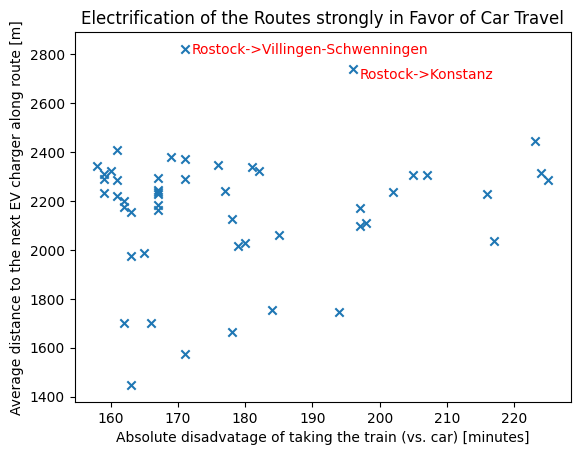

In [20]:
plt.scatter(df_routes_to_analyse["absolute_deviation"], df_routes_to_analyse["avg_dist_charger"], marker="x")
plt.xlabel("Absolute disadvatage of taking the train (vs. car) [minutes]")
plt.ylabel("Average distance to the next EV charger along route [m]")
plt.title("Electrification of the Routes strongly in Favor of Car Travel")
plt.annotate("Rostock->Villingen-Schwenningen", (172, 2800), color="red")
plt.annotate("Rostock->Konstanz", (197, 2700), color="red")

Least electrified and most disadvantageous train routes: Rostock/Villingen-Schwenningen (next charger in 2.8km) and Rostock/Konstanz (next charger in 2.7km):

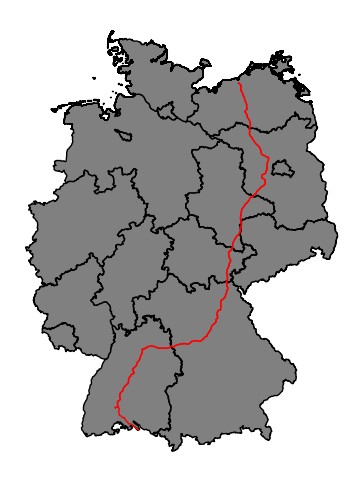

In [21]:
plot_routes_on_germany_map(df_routes_to_analyse[df_routes_to_analyse["avg_dist_charger"]>2700], color="red")

### EV Chargers in Germany

In [22]:
cnx = sqlite3.connect('data/charging_points_development.sqlite')
df_development = pd.read_sql_query("SELECT * FROM districts", cnx)

,chargers
state,
Bayern,17535
Nordrhein-Westfalen,15776
Baden-Württemberg,15531
Niedersachsen,8479
Hessen,6604
Schleswig-Holstein,3500
Sachsen,3449
Rheinland-Pfalz,3266
Berlin,2414


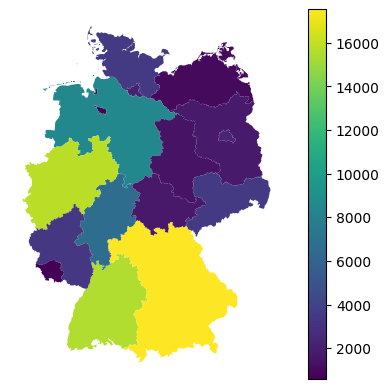

In [23]:
df_chargers_states = df_development[["state", "2023"]]
df_chargers_states = df_chargers_states.rename(columns={"2023":"chargers"})
df_chargers_states = df_chargers_states.groupby("state")["chargers"].sum()

import geopandas as gpd
df_states = gpd.read_file('./GER_shape/DEU_adm1.shp')
df_states = df_states.set_index('NAME_1')
df_states["chargers-2023"] = df_chargers_states

df_states.plot(column="chargers-2023", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_chargers_states).sort_values(by="chargers", ascending=False)

### Development of EV charging stations overall in Germany

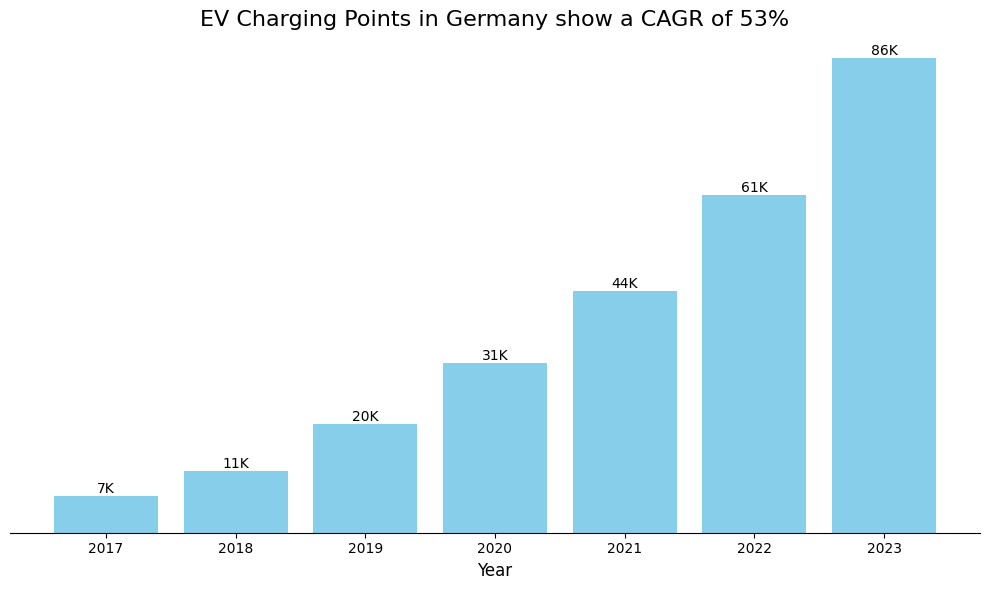

In [24]:
years = [str(d) for d in range(2017,2024)]
values = df_development.sum(axis=0)[2:]

plt.figure(figsize=(10, 6))
bars = plt.bar(years, values, color='skyblue')  # Use a professional color

plt.title('EV Charging Points in Germany show a CAGR of 53%', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Points', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().yaxis.set_visible(False)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(int(round(yval/1000, 0)))+"K", 
             verticalalignment='bottom', horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

### Development of charging stations per district

In [25]:
cagr = ((df_development["2023"] / df_development["2020"]) ** (1 / 3) - 1) * 100
df_development["CAGR-3"] = cagr
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][:5]

,location,state,CAGR-3
123,Regen,Bayern,-5.940289
132,Straubing-Bogen,Bayern,6.917811
211,Friesland,Niedersachsen,9.204330
160,Bremerhaven,Bremen,10.064242
158,Uckermark,Brandenburg,11.804676


In [26]:
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][-5:]

,location,state,CAGR-3
42,Stuttgart,Baden-Württemberg,131.090655
171,Groß-Gerau,Hessen,132.587532
313,Cochem-Zell,Rheinland-Pfalz,149.331548
155,Prignitz,Brandenburg,151.984210
189,Schwerin,Mecklenburg-Vorpommern,233.222185


NAME_1
Saarland                  70.064454
Mecklenburg-Vorpommern    69.500122
Brandenburg               54.972203
Baden-Württemberg         46.882587
Hessen                    45.541177
Sachsen                   44.116820
Rheinland-Pfalz           42.932372
Bayern                    42.505295
Nordrhein-Westfalen       41.795339
Niedersachsen             40.807948
Schleswig-Holstein        38.877050
Sachsen-Anhalt            38.403632
Thüringen                 35.770980
Berlin                    33.482318
Hamburg                   22.102430
Bremen                    20.678124
Name: CAGR-3, dtype: float64

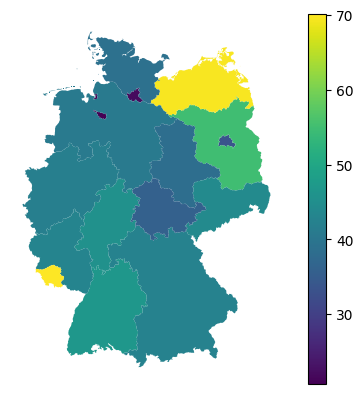

In [27]:
df_states["CAGR-3"] = df_development.groupby("state")["CAGR-3"].mean()

df_states.plot(column="CAGR-3", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_states).sort_values(by="CAGR-3", ascending=False)["CAGR-3"]

## Discussion

### Interpretation
This report has given an overview over the competitiveness of train travel versus car travel in terms of travel time.
On average, taking the train is 30 minutes or 19% longer than taking the car. Additionally, taking the car is faster for more than 76% of analysed routes.
This paints a dull picture of the German railway system. When making the decision of always driving by car, on average, a person will be faster than taking the train. This gives little incentive to reflect on one's travelling decisions.

The largest relative deviations have shown up in the state of Nordrhein-Westfalen, with a striking 250% longer travel time between Duisburg and Moers when using a train connection. The shorter travel routes pose a higher risk of having large deviations, as even one minute difference can alter the ratio significantly.

The analysis has shown that the routes with the largest absolute deviation are routes which span over the whole map area of Germany ("most disadvantageous routes"). This is not surprising, as longer routes have more potential to accumulate delays when there is even only a small difference in travel speed. The route with the largest absolute advatage of car travel is the route Konstanz-Chemnitz (and also the reverse route) with more than 3.5 hours (225 minutes) difference.

For the most disadvantageous routes, the degree of electrification is assessed. The analysis has shown, that for these routes, there are 5.5 chargers per 10km of travel distance, and on average, the next charger is 2.1km away.

Two routes have shown to be below-average in terms of electrification: Rostock/Villingen-Schwenningen (next charger every 2.8km) and Rostock/Konstanz (next charger every 2.7km).
While their charger density is slightly above average, there seem to be regions which are charging deserts.

The further analysis of existing ev chargers has shown that the eastern-German states and the state Rheinland-Pfalz as well as Saarland have the least chargers.

The development of the charging infrastructure form 2017 to 2023 has shown an impressive cumulative average growth rate (CAGR) of 53% yearly, with the district of Stuttgart showing even a CAGR of 130%.

Interestingly, there was one district showing a negative growth rate since 2020, which was Regen in Bayern with -5.9% growth.

Overall, the states Mecklenburg-Vorpommern and Saarland have shown the largest growth over the last six years, with about 70% CAGR for both.

<b>Answering the Main Question</b>

With the analysis of the train-system and the electrification of the routes, this report recommends two routes for priority in electrification: Rostock/Villingen-Schwenningen and Rostock/Konstanz.

### Limitations
While this report assesses the degree of electrification of a whole route, it does not investigate the different parts of a route. The sampling of points along the routes only gives an average, and not insight into specific areas in Germany.

Additionally, the most disadvantageous routes (by train) are only compared to each other w.r.t. electrification, and not the whole German average.

Further, the recommendation of priority in electrification is made only on the basis of two pieces of data: the disadvatage of taking a train, and the degree of electrification.

### Outlook
For future analyses, it would be interesting to see which parts of the routes are not electrified well, to align this to specific districts in Germany.
To make a more cost-efficient recommendation, a further analysis should also look at the number of passengers travelling along each route, to find the routes for whom an electrification would save the most total emissions.